Station: MOHEMBO/MTAEMBO, GRDC: 1357100, River: OKAVANGO RIVER
Lat/Lon: -18.283333, 21.8
Unit: m³/s, Time series: 1974-12 - 2024-02
Daily rows: 17,973 | Range: 1974-12-04 → 2024-02-17
Saved: mohembo_1357100_Q_daily.csv
Saved: mohembo_1357100_Q_monthly_mean.csv


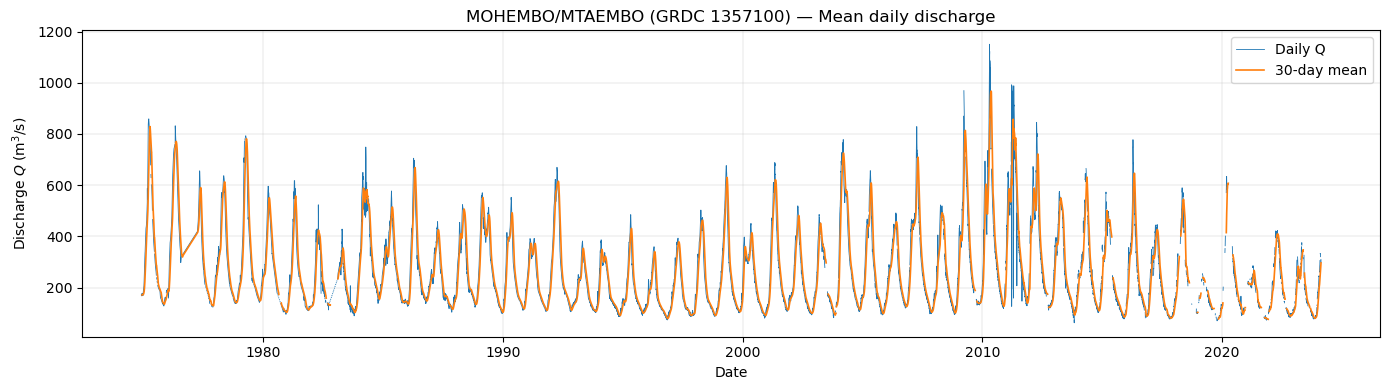

In [1]:
# Mohembo/Mtaembo (GRDC 1357100) — standalone notebook cell
from __future__ import annotations

from pathlib import Path
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --------------------
# Config
# --------------------
DATA_DIR = Path("../GRDC_station_data")
FILE_NAME = "1357100_Q_Day.Cmd.txt"          # Mohembo/Mtaembo
OUT_DAILY_CSV = Path("../data/mohembo_1357100_Q_daily.csv")
OUT_MONTHLY_CSV = Path("../data/mohembo_1357100_Q_monthly_mean.csv")

META_RE = re.compile(r"^#\s*(?P<key>[^:]+):\s*(?P<val>.*)\s*$")


def _to_float(x) -> float:
    """Robust float parsing (handles commas/whitespace/None)."""
    if x is None:
        return np.nan
    s = str(x).strip().replace(",", ".")
    return pd.to_numeric(s, errors="coerce")


def _parse_filename(fp: Path) -> dict:
    """
    Many GRDC files look like: 1357100_Q_Day.Cmd.txt
    Extract station id + variable tag from filename when possible.
    """
    m = re.match(r"^(?P<id>\d+)_(?P<tag>.+?)\.Cmd\.txt$", fp.name)
    if not m:
        return {"file_station_id": np.nan, "file_tag": fp.stem}
    return {
        "file_station_id": pd.to_numeric(m.group("id"), errors="coerce"),
        "file_tag": m.group("tag"),
    }


def read_grdc_cmd_file(fp: str | Path, encoding: str = "latin-1") -> tuple[dict, pd.DataFrame]:
    """
    Read a GRDC *.Cmd.txt file.

    Returns
    -------
    meta : dict
        Metadata (raw + standardized fields)
    ts : pd.DataFrame
        Time series with DatetimeIndex and numeric data columns
    """
    fp = Path(fp)

    # --------- metadata (header) ----------
    meta_raw = {"source_file": fp.name, "source_path": str(fp)}
    meta_raw.update(_parse_filename(fp))

    with open(fp, "r", encoding=encoding, errors="replace") as f:
        for line in f:
            if not line.startswith("#"):
                continue
            m = META_RE.match(line)
            if m:
                meta_raw[m.group("key").strip()] = m.group("val").strip()

    # Standardize a few common keys (keep raw keys too)
    keymap = {
        "GRDC-No.": "grdc_no",
        "River": "river",
        "Station": "station_raw",
        "Country": "country",
        "Latitude (DD)": "lat",
        "Longitude (DD)": "lon",
        "Catchment area (km²)": "catchment_area_km2",
        "Catchment area (km�)": "catchment_area_km2",
        "Catchment area (km\xb2)": "catchment_area_km2",
        "Altitude (m ASL)": "altitude_m",
        "file generation date": "file_generation_date",
        "Last update": "last_update",
        "Data Set Content": "dataset_content",
        "Unit of measure": "unit",
        "Time series": "time_series",
        "Data lines": "data_lines",
    }

    meta = dict(meta_raw)
    for raw_k, std_k in keymap.items():
        if raw_k in meta_raw:
            meta[std_k] = meta_raw[raw_k]

    # Station name/code split like: "MOHEMBO/MTAEMBO (67932112)"
    if isinstance(meta.get("station_raw"), str):
        m = re.match(r"^(.*?)\s*\((.*?)\)\s*$", meta["station_raw"])
        if m:
            meta["station_name"] = m.group(1).strip()
            meta["station_code"] = m.group(2).strip()
        else:
            meta["station_name"] = meta["station_raw"].strip()

    # Numeric conversions
    if "grdc_no" in meta:
        meta["grdc_no"] = pd.to_numeric(str(meta["grdc_no"]).strip(), errors="coerce")
    for k in ("lat", "lon", "catchment_area_km2", "altitude_m"):
        if k in meta:
            meta[k] = _to_float(meta[k])
    if "data_lines" in meta:
        meta["data_lines"] = pd.to_numeric(str(meta["data_lines"]).strip(), errors="coerce")

    # --------- time series table ----------
    df = pd.read_csv(
        fp,
        sep=";",
        comment="#",
        skip_blank_lines=True,
        dtype=str,
        encoding=encoding,
    )

    # Clean column names + strip whitespace
    df.columns = [c.strip() for c in df.columns]
    for c in df.columns:
        df[c] = df[c].astype(str).str.strip()

    date_col = df.columns[0]
    time_col = df.columns[1] if len(df.columns) >= 2 else None

    # Parse datetime
    date = pd.to_datetime(df[date_col], format="%Y-%m-%d", errors="coerce")

    if time_col is not None:
        has_times = (~df[time_col].isin(["--:--", "--", "", "nan", "None"])).any()
        if has_times:
            t = df[time_col].replace({"--:--": "00:00", "--": "00:00", "": "00:00"})
            dt = pd.to_datetime(df[date_col] + " " + t, format="%Y-%m-%d %H:%M", errors="coerce")
        else:
            dt = date
    else:
        dt = date

    # Convert remaining columns to numeric; set missing flags to NaN
    drop_cols = [date_col] + ([time_col] if time_col is not None else [])
    data_cols = [c for c in df.columns if c not in drop_cols]

    out = df[data_cols].replace(
        {
            "-999.000": np.nan,
            "-999.00": np.nan,
            "-999.0": np.nan,
            "-999": np.nan,
            "": np.nan,
            "nan": np.nan,
            "None": np.nan,
        }
    )
    for c in data_cols:
        out[c] = pd.to_numeric(out[c], errors="coerce")

    out.insert(0, "datetime", dt)
    out = out.dropna(subset=["datetime"]).set_index("datetime").sort_index()

    return meta, out


def pick_discharge_column(ts: pd.DataFrame) -> str:
    """Pick the most likely discharge column from a GRDC table."""
    numeric_cols = [c for c in ts.columns if pd.api.types.is_numeric_dtype(ts[c])]
    if not numeric_cols:
        raise ValueError("No numeric columns found in time series table.")

    if len(numeric_cols) == 1:
        return numeric_cols[0]

    # Prefer columns named like discharge/Q/value
    for pat in [r"^\s*Q\s*$", r"discharge", r"\bflow\b", r"value"]:
        for c in numeric_cols:
            if re.search(pat, c, flags=re.IGNORECASE):
                return c

    # Fallback: first numeric column
    return numeric_cols[0]


# --------------------
# Load Mohembo + extract + save
# --------------------
fp = DATA_DIR / FILE_NAME
meta, ts = read_grdc_cmd_file(fp)

q_col = pick_discharge_column(ts)
ts = ts.rename(columns={q_col: "Q_m3s"})

# Add handy columns
ts = ts.assign(
    year=ts.index.year,
    month=ts.index.month,
    grdc_no=int(meta["grdc_no"]) if pd.notna(meta.get("grdc_no")) else np.nan,
    station=meta.get("station_name", "MOHEMBO/MTAEMBO"),
)

# Save daily series
ts[["Q_m3s", "year", "month", "grdc_no", "station"]].to_csv(OUT_DAILY_CSV, index_label="date")

# Save monthly mean series (calendar months)
monthly = ts["Q_m3s"].resample("MS").mean().to_frame("Q_m3s_monthly_mean")
monthly.to_csv(OUT_MONTHLY_CSV, index_label="month")

print(f"Station: {meta.get('station_name','')}, GRDC: {meta.get('grdc_no','')}, River: {meta.get('river','')}")
print(f"Lat/Lon: {meta.get('lat','')}, {meta.get('lon','')}")
print(f"Unit: {meta.get('unit','m^3/s')}, Time series: {meta.get('time_series','')}")
print(f"Daily rows: {len(ts):,} | Range: {ts.index.min().date()} → {ts.index.max().date()}")
print(f"Saved: {OUT_DAILY_CSV}")
print(f"Saved: {OUT_MONTHLY_CSV}")

# --------------------
# Plot (daily + 30-day mean)
# --------------------
fig, ax = plt.subplots(figsize=(14, 4))

ax.plot(ts.index, ts["Q_m3s"], linewidth=0.6, label="Daily Q")

q_30d = ts["Q_m3s"].rolling("30D", min_periods=10).mean()
ax.plot(q_30d.index, q_30d, linewidth=1.2, label="30-day mean")

title = f"{meta.get('station_name','MOHEMBO/MTAEMBO')} (GRDC {int(meta['grdc_no'])}) — Mean daily discharge"
ax.set_title(title)
ax.set_xlabel("Date")
ax.set_ylabel(r"Discharge $Q$ (m$^3$/s)")
ax.grid(True, linewidth=0.2)
ax.legend()

fig.tight_layout()
plt.show()



In [2]:
!open ../GRDC_station_data/1357100_Q_Day.Cmd.txt

In [3]:
# mohembo + chirps + dswe + cygnss (monthly) — standalone notebook
from __future__ import annotations
from pathlib import Path
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --------------------
# paths / switches
# --------------------
grdc_file = Path("../GRDC_station_data/1357100_Q_Day.Cmd.txt")  # mohembo/mtaembo
chirps_csv = Path("../data/chirps_monthly_by_regions.csv")

cygnss_crops_dir = Path("../data/cygnss_okavango_full/crops_nc_clip")
cygnss_threshold = 0.5
cygnss_varname = None  # set if the debug print shows the wrong band

run_ee_dswe = True

okavango_shp = Path("../data/regions/Delta_UCB_WGS84/Delta_UCB_WGS84.shp")  # from your dswe notebook
okavango_geom_asset = None  # e.g. "projects/.../okavango_outline"

landsat_dswe_path = "projects/ee-okavango/assets/water_masks/monthly_DSWE_Landsat_30m_v4/DSWE_Products"
sentinel_dswe_path = "projects/ee-okavango/assets/water_masks/monthly_DSWE_Sent2_10m_v2/DSWE_Products"

out_csv = Path("../data/okavango_mohembo_chirps_dswe_cygnss_monthly.csv")


# =========================
# 1) mohembo: grdc daily -> monthly mean q
# =========================
meta_re = re.compile(r"^#\s*(?P<key>[^:]+):\s*(?P<val>.*)\s*$")

def _to_float(x) -> float:
    if x is None:
        return np.nan
    s = str(x).strip().replace(",", ".")
    return pd.to_numeric(s, errors="coerce")

def read_grdc_cmd_file(fp: str | Path, encoding: str = "latin-1") -> tuple[dict, pd.DataFrame]:
    fp = Path(fp)

    meta_raw = {"source_file": fp.name, "source_path": str(fp)}
    with open(fp, "r", encoding=encoding, errors="replace") as f:
        for line in f:
            if not line.startswith("#"):
                continue
            m = meta_re.match(line)
            if m:
                meta_raw[m.group("key").strip()] = m.group("val").strip()

    keymap = {
        "GRDC-No.": "grdc_no",
        "River": "river",
        "Station": "station_raw",
        "Country": "country",
        "Latitude (DD)": "lat",
        "Longitude (DD)": "lon",
        "Unit of measure": "unit",
        "Time series": "time_series",
    }
    meta = dict(meta_raw)
    for raw_k, std_k in keymap.items():
        if raw_k in meta_raw:
            meta[std_k] = meta_raw[raw_k]

    if isinstance(meta.get("station_raw"), str):
        m = re.match(r"^(.*?)\s*\((.*?)\)\s*$", meta["station_raw"])
        meta["station_name"] = m.group(1).strip() if m else meta["station_raw"].strip()

    if "grdc_no" in meta:
        meta["grdc_no"] = pd.to_numeric(str(meta["grdc_no"]).strip(), errors="coerce")
    for k in ("lat", "lon"):
        if k in meta:
            meta[k] = _to_float(meta[k])

    df = pd.read_csv(fp, sep=";", comment="#", skip_blank_lines=True, dtype=str, encoding=encoding)
    df.columns = [c.strip() for c in df.columns]
    for c in df.columns:
        df[c] = df[c].astype(str).str.strip()

    date_col = df.columns[0]
    time_col = df.columns[1] if len(df.columns) >= 2 else None

    date = pd.to_datetime(df[date_col], format="%Y-%m-%d", errors="coerce")
    if time_col is not None:
        has_times = (~df[time_col].isin(["--:--", "--", "", "nan", "None"])).any()
        if has_times:
            t = df[time_col].replace({"--:--": "00:00", "--": "00:00", "": "00:00"})
            dt = pd.to_datetime(df[date_col] + " " + t, format="%Y-%m-%d %H:%M", errors="coerce")
        else:
            dt = date
    else:
        dt = date

    drop_cols = [date_col] + ([time_col] if time_col is not None else [])
    data_cols = [c for c in df.columns if c not in drop_cols]

    out = df[data_cols].replace(
        {"-999.000": np.nan, "-999.00": np.nan, "-999.0": np.nan, "-999": np.nan, "": np.nan, "nan": np.nan}
    )
    for c in data_cols:
        out[c] = pd.to_numeric(out[c], errors="coerce")

    out.insert(0, "datetime", dt)
    out = out.dropna(subset=["datetime"]).set_index("datetime").sort_index()
    return meta, out

def pick_first_numeric_col(ts: pd.DataFrame) -> str:
    numeric_cols = [c for c in ts.columns if pd.api.types.is_numeric_dtype(ts[c])]
    if not numeric_cols:
        raise ValueError("no numeric columns found in grdc time series table")
    return numeric_cols[0]

meta_moh, ts_moh = read_grdc_cmd_file(grdc_file)
q_col = pick_first_numeric_col(ts_moh)
q_daily = ts_moh.rename(columns={q_col: "q_m3s"})[["q_m3s"]].copy()
q_monthly = q_daily.resample("MS").mean().rename(columns={"q_m3s": "q_m3s_monthly_mean"})
q_monthly.index.name = "month"

print(f"mohembo: {meta_moh.get('station_name','')} (grdc {int(meta_moh['grdc_no'])})")
print(f"q daily: {q_daily.index.min().date()} → {q_daily.index.max().date()} | n={len(q_daily):,}")


# =========================
# 2) chirps: monthly rain by combined regions
# =========================
combine_map = {
    "highland_cuito":      "highlands",
    "highland_cubango":    "highlands",
    "east_lower_okavango": "delta",
    "west_lower_okavango": "delta",
    "seronga":             "delta",
}

chirps_df = pd.read_csv(chirps_csv)
df_ch = chirps_df[chirps_df["region_id"].isin(combine_map.keys())].copy()
df_ch["region_group"] = df_ch["region_id"].map(combine_map)

if "ym" in df_ch.columns:
    dt = pd.to_datetime(df_ch["ym"], errors="coerce")
elif "date" in df_ch.columns:
    dt = pd.to_datetime(df_ch["date"], errors="coerce")
else:
    raise ValueError("chirps csv must have either a 'ym' column or a 'date' column")

df_ch["month"] = pd.to_datetime(dict(year=dt.dt.year, month=dt.dt.month, day=1))
chirps_grp = (
    df_ch.groupby(["region_group", "month"], as_index=False)["precip_mm"]
        .mean()
)

precip = (
    chirps_grp.pivot(index="month", columns="region_group", values="precip_mm")
        .rename(columns={"highlands": "rain_highlands_mm", "delta": "rain_delta_mm"})
        .sort_index()
)
precip.index = precip.index.to_period("M").to_timestamp()
precip.index.name = "month"


# =========================
# 3) cygnss: monthly inundation area (km²) from okav_yyyy-mm.nc
#     (fix: choose a water/mask-like var and handle time dim)
# =========================
import xarray as xr

earth_radius_m = 6_371_008.8  # meters

def _timestamp_from_filename(path: Path) -> pd.Timestamp:
    m = re.search(r"(\d{4})-(\d{2})", path.name)
    if not m:
        raise ValueError(f"filename must contain yyyy-mm: {path.name}")
    y, mo = int(m.group(1)), int(m.group(2))
    return pd.Timestamp(year=y, month=mo, day=1)

def _cell_area_km2(lat_1d: np.ndarray, dlat_deg: float, dlon_deg: float) -> np.ndarray:
    lat_1d = np.asarray(lat_1d, dtype=float)
    dlat = np.deg2rad(dlat_deg)
    dlon = np.deg2rad(dlon_deg)
    area_m2 = (earth_radius_m**2) * dlat * dlon * np.cos(np.deg2rad(lat_1d))
    return area_m2 / 1e6  # km²

def cygnss_monthly_inundation_df(
    crops_dir: str | Path,
    threshold: float = 0.5,
    varname: str | None = None,
    verbose: bool = True) -> pd.DataFrame:
    crops_dir = Path(crops_dir)
    paths = sorted(crops_dir.glob("okav_*.nc"), key=lambda p: p.name)
    if not paths:
        raise FileNotFoundError(f"no okav_*.nc files found in {crops_dir}")

    rows = []
    printed = False

    for p in paths:
        month = _timestamp_from_filename(p).to_period("M").to_timestamp()
        ds = xr.open_dataset(p)

        lat = ds["lat"].values
        lon = ds["lon"].values

        if varname is None:
            cand = [v for v in ds.data_vars if ("mask" in v.lower()) or ("water" in v.lower())]
            vname = cand[0] if cand else list(ds.data_vars)[0]
        else:
            vname = varname

        da = ds[vname]

        tdim = next((d for d in da.dims if d.lower().startswith("time")), None)
        if tdim is not None:
            da = da.isel({tdim: 0}).squeeze(drop=True)

        if lat.ndim != 1:
            lat = np.unique(lat)
        if lon.ndim != 1:
            lon = np.unique(lon)

        dlat = float(np.abs(lat[1] - lat[0]))
        dlon = float(np.abs(lon[1] - lon[0]))

        row_area = _cell_area_km2(lat, dlat, dlon)
        area_grid = np.repeat(row_area[:, None], len(lon), axis=1)

        arr = np.asarray(da)
        mask = np.isfinite(arr) & (arr >= threshold)
        water_km2 = float((area_grid * mask).sum())

        if verbose and not printed:
            a_min = float(np.nanmin(arr))
            a_max = float(np.nanmax(arr))
            print(f"cygnss debug: {p.name} | var='{vname}' | min/max={a_min:.3g}/{a_max:.3g} | km²={water_km2:.1f}")
            print(f"cygnss debug: data_vars={list(ds.data_vars)}")
            printed = True

        rows.append({"month": month, "cygnss_km2": water_km2})
        ds.close()

    return pd.DataFrame(rows).set_index("month").sort_index()

cyg = cygnss_monthly_inundation_df(
    cygnss_crops_dir,
    threshold=cygnss_threshold,
    varname=cygnss_varname,
    verbose=True,
)


# =========================
# 4) dswe: ee monthly pixel-count -> km² (landsat + sentinel)
# =========================
dswe = None

if run_ee_dswe:
    import ee
    import geemap

    try:
        ee.Initialize()
    except Exception:
        ee.Authenticate()
        ee.Initialize()

    def list_image_ids(path: str):
        assets = ee.data.listAssets(path).get("assets", [])
        return [a["id"] for a in assets if a.get("type") == "IMAGE"]

    def load_okavango_geometry():
        if okavango_geom_asset:
            return ee.FeatureCollection(okavango_geom_asset).geometry()
        if okavango_shp.exists():
            ok_fc = geemap.shp_to_ee(str(okavango_shp))
            return ok_fc.geometry().dissolve(maxError=100)
        raise FileNotFoundError("set okavango_geom_asset or make sure okavango_shp exists")

    okavango = load_okavango_geometry()

    def load_landsat_dswe(asset_id: str):
        year = ee.String(asset_id).split("_").get(-2)
        month = ee.String(asset_id).split("_").get(-1)
        img = ee.Image(asset_id)
        dswe_bin = img.gt(0).toFloat().rename("dswe_bin")
        return img.addBands(dswe_bin).set({"year": year, "month": month})

    def load_sentinel_dswe(asset_id: str):
        year = ee.String(asset_id).split("_").get(-2)
        month = ee.String(asset_id).split("_").get(-1)
        img = ee.Image(asset_id)
        dswe_bin = img.gt(0).toFloat().rename("dswe_bin")
        return img.addBands(dswe_bin).set({"year": year, "month": month})

    def monthly_dswe_counts(ic: "ee.ImageCollection", scale_m: int) -> pd.DataFrame:
        def add_pixel_count(img):
            count = (
                img.select("dswe_bin")
                   .reduceRegion(ee.Reducer.sum(), okavango, scale=scale_m, maxPixels=1e13)
                   .get("dswe_bin")
            )
            year = ee.Number.parse(img.get("year"))
            month = ee.Number.parse(img.get("month"))
            date_str = ee.Date.fromYMD(year, month, 1).format("YYYY-MM")
            return img.set({"date": date_str, "count": count})

        ts_ic = ic.sort("year").sort("month").map(add_pixel_count)
        fc = ee.FeatureCollection(ts_ic.map(lambda im: ee.Feature(None, im.toDictionary(["date", "count"]))))

        info = fc.getInfo()
        rows = [f["properties"] for f in info["features"]]
        df = pd.DataFrame(rows)
        df["month"] = pd.to_datetime(df["date"], format="%Y-%m", errors="coerce").dt.to_period("M").dt.to_timestamp()
        df["count"] = pd.to_numeric(df["count"], errors="coerce").fillna(0.0)
        return df.dropna(subset=["month"]).sort_values("month")

    px30_km2 = 0.0009  # 30m pixel area
    px10_km2 = px30_km2 / 9.0  # 10m pixel area

    ls_ids = list_image_ids(landsat_dswe_path)
    s2_ids = list_image_ids(sentinel_dswe_path)

    ls_ic = ee.ImageCollection([load_landsat_dswe(i) for i in ls_ids])
    s2_ic = ee.ImageCollection([load_sentinel_dswe(i) for i in s2_ids])

    df_ls = monthly_dswe_counts(ls_ic, scale_m=30)
    df_s2 = monthly_dswe_counts(s2_ic, scale_m=10)

    dswe = (
        df_ls.assign(dswe_ls_km2=df_ls["count"] * px30_km2)
             .set_index("month")[["dswe_ls_km2"]]
             .join(
                 df_s2.assign(dswe_s2_km2=df_s2["count"] * px10_km2).set_index("month")[["dswe_s2_km2"]],
                 how="outer",
             )
             .sort_index()
    )


# =========================
# 5) combine + save + plot
# =========================
df = q_monthly.join(precip, how="outer").join(cyg, how="outer")
if dswe is not None:
    df = df.join(dswe, how="outer")
df = df.sort_index()



mohembo: MOHEMBO/MTAEMBO (grdc 1357100)
q daily: 1974-12-04 → 2024-02-17 | n=17,973
cygnss debug: okav_2018-08.nc | var='watermask' | min/max=0/1 | km²=11081.3
cygnss debug: data_vars=['spatial_ref', 'watermask']


In [4]:
chirps_csv

PosixPath('../data/chirps_monthly_by_regions.csv')

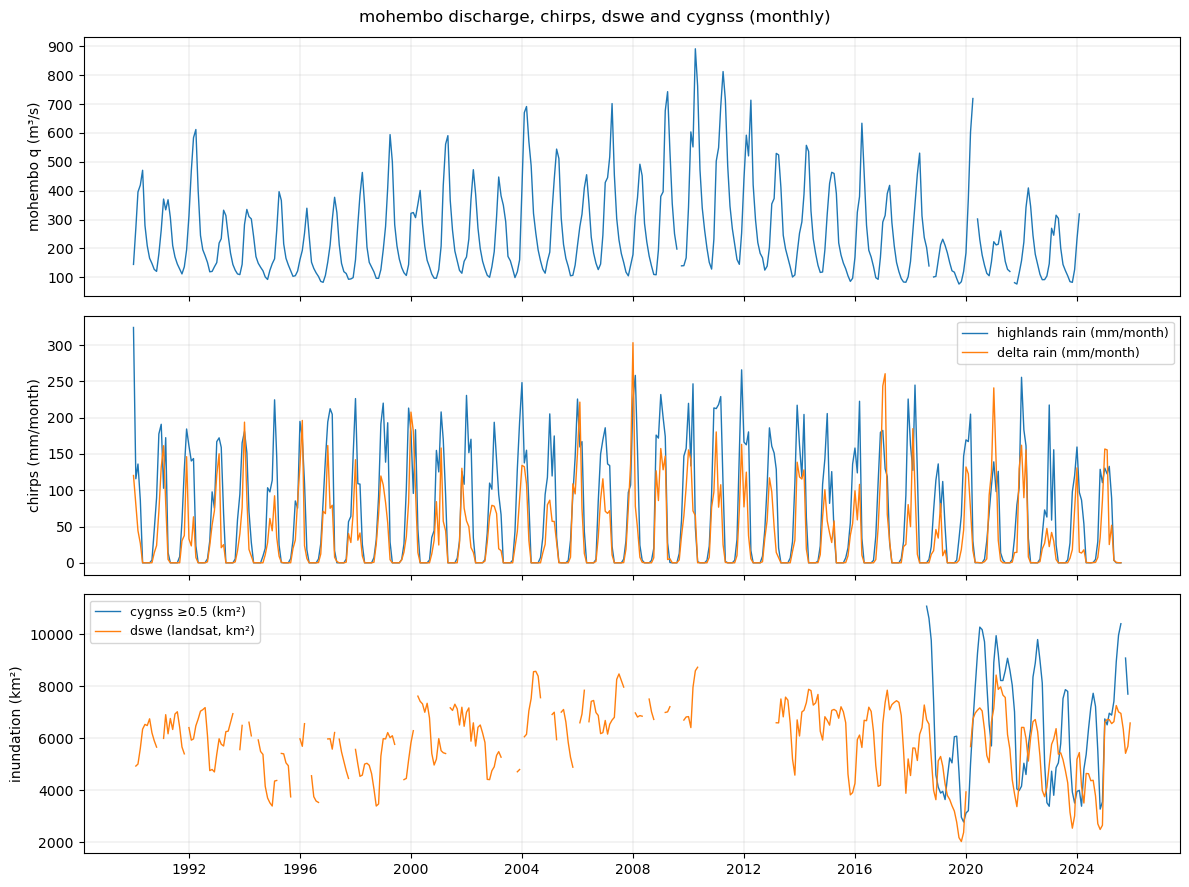

In [5]:
# drop-in: limit everything to 1990+ (monthly index is the first of each month)
start = pd.Timestamp("1990-01-01")

df_1990 = df.loc[df.index >= start].copy()

fig, axes = plt.subplots(3, 1, figsize=(12, 9), sharex=True)

ax = axes[0]
ax.plot(df_1990.index, df_1990["q_m3s_monthly_mean"], linewidth=1.0)
ax.set_ylabel("mohembo q (m³/s)")
ax.grid(True, linewidth=0.2)

ax = axes[1]
if "rain_highlands_mm" in df_1990.columns:
    ax.plot(df_1990.index, df_1990["rain_highlands_mm"], linewidth=1.0, label="highlands rain (mm/month)")
if "rain_delta_mm" in df_1990.columns:
    ax.plot(df_1990.index, df_1990["rain_delta_mm"], linewidth=1.0, label="delta rain (mm/month)")
ax.set_ylabel("chirps (mm/month)")
ax.legend(loc="best", fontsize=9)
ax.grid(True, linewidth=0.2)

ax = axes[2]
if "cygnss_km2" in df_1990.columns:
    ax.plot(df_1990.index, df_1990["cygnss_km2"], linewidth=1.0, label=f"cygnss ≥{cygnss_threshold} (km²)")
if "dswe_ls_km2" in df_1990.columns:
    ax.plot(df_1990.index, df_1990["dswe_ls_km2"], linewidth=1.0, label="dswe (landsat, km²)")
ax.set_ylabel("inundation (km²)")
ax.legend(loc="best", fontsize=9)
ax.grid(True, linewidth=0.2)

fig.suptitle("mohembo discharge, chirps, dswe and cygnss (monthly)", y=0.98)
plt.tight_layout()
plt.show()


In [6]:
# combined monthly dataframe (1990+) + save

start = pd.Timestamp("1990-01-01")

df_combined = (
    q_monthly
    .join(precip, how="outer")
    .join(cyg, how="outer")
)

if dswe is not None:
    df_combined = df_combined.join(dswe, how="outer")

df_combined = df_combined.sort_index()
df_combined = df_combined.loc[df_combined.index >= start].copy()

# optional: add explicit year/month cols for convenience
df_combined["year"] = df_combined.index.year
df_combined["month_num"] = df_combined.index.month

# inspect
print(df_combined.head())


            q_m3s_monthly_mean  rain_delta_mm  rain_highlands_mm  cygnss_km2  \
month                                                                          
1990-01-01          144.700968     120.255636         324.201135         NaN   
1990-02-01          270.588929      79.864579         115.790675         NaN   
1990-03-01          395.561613      44.176758         136.100929         NaN   
1990-04-01          419.280667      26.840830          86.174812         NaN   
1990-05-01          470.686452       0.000000           0.000000         NaN   

            dswe_ls_km2  dswe_s2_km2  year  month_num  
month                                                  
1990-01-01          NaN          NaN  1990          1  
1990-02-01  4933.546789          NaN  1990          2  
1990-03-01  5010.307595          NaN  1990          3  
1990-04-01  5617.024101          NaN  1990          4  
1990-05-01  6352.790231          NaN  1990          5  


In [7]:
# Ensure monthly grid (inserts missing months as NaN rows), then fill only 1-month gaps
# df_combined = df_combined.sort_index().asfreq("MS")

# don't touch convenience cols
skip = {"year", "month_num"}
cols = [c for c in df_combined.columns if c not in skip]

# linear (time) interpolation, but only for interior gaps and only up to 1 missing month
df_combined[cols] = df_combined[cols].interpolate(
    method="time", limit=1, limit_area="inside"
)

# (optional) re-derive convenience cols if you want them to stay consistent after asfreq
df_combined["year"] = df_combined.index.year
df_combined["month_num"] = df_combined.index.month


<Axes: xlabel='month'>

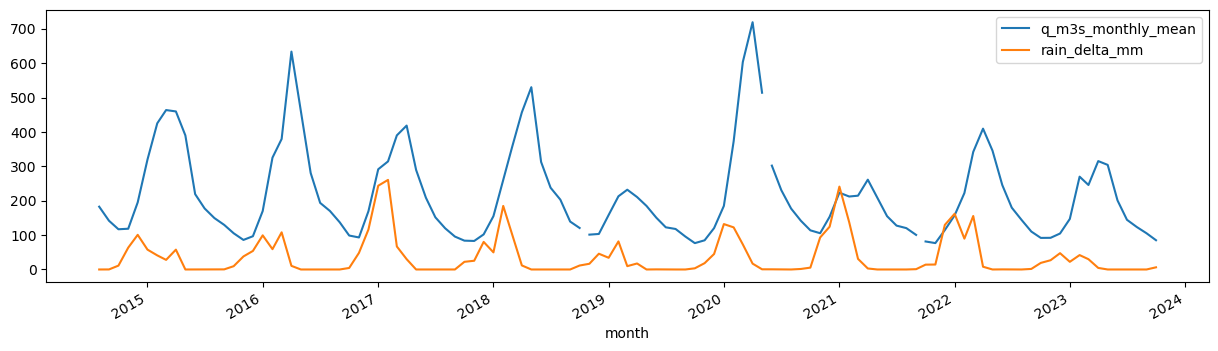

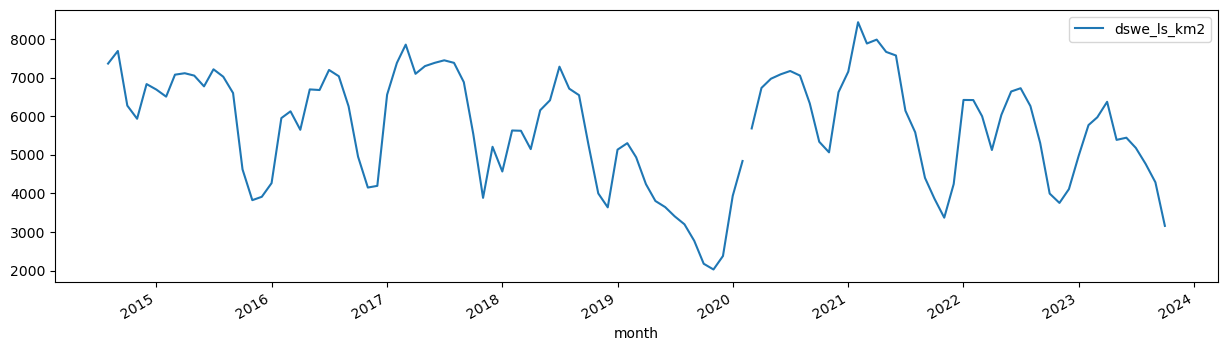

In [8]:
plt.figure(figsize = (15, 4))
df_combined[['q_m3s_monthly_mean', 'rain_delta_mm']][-400:-100].plot(ax= plt.gca())

plt.figure(figsize = (15, 4))
df_combined[['dswe_ls_km2']][-400:-100].plot(ax= plt.gca())

In [9]:
# convert mohembo q (m3/s) -> mm/month over the same polygons used for chirps rainfall

import geopandas as gpd
import numpy as np
import pandas as pd

# expects you already built df_combined with:
#   - index = month starts (DatetimeIndex)
#   - column "q_m3s_monthly_mean"
# chirps regions came from this shapefile:
regions_shp = Path("../data/regions/Delta_UCB_WGS84/Delta_UCB_WGS84.shp")

regions = gpd.read_file(regions_shp)
if regions.crs is None:
    raise ValueError("regions_shp has no CRS. If it's lon/lat, do: regions = regions.set_crs('EPSG:4326')")

# compute polygon areas (km²) in an equal-area CRS
regions_eq = regions.to_crs(6933)  # equal-area
regions = regions.copy()
regions["area_km2"] = regions_eq.geometry.area / 1e6

# # seconds in each calendar month (aligned to df_combined index)
sec_in_month = pd.Series(
    df_combined.index.to_period("M").days_in_month.astype(float) * 86400.0,
    index=df_combined.index
)


df_combined["q_mm_month_delta"] = (
    df_combined["q_m3s_monthly_mean"] * sec_in_month / (regions["area_km2"][0] * 1000.0)
)

# df_combined[["q_m3s_monthly_mean", "q_mm_month_highlands", " q"]].head()
# 12,000
regions["area_km2"][0]/2

# TODO: double check chirps downloads. 
#     

11658.513282027487

Text(0, 0.5, 'mm')

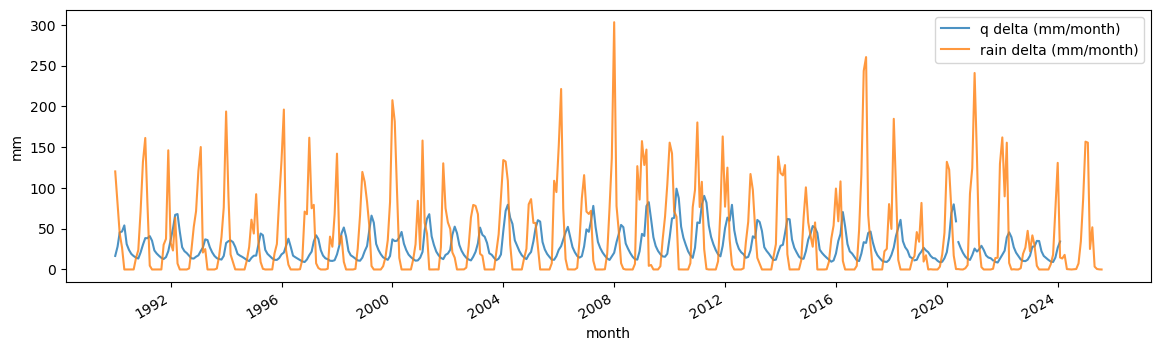

In [10]:
plt.figure(figsize = (14,4))
df_combined[['q_mm_month_delta', 'rain_delta_mm']].rename({'q_mm_month_delta': "q delta (mm/month)",
                                                           'rain_delta_mm' : 'rain delta (mm/month)'}, axis= 1)[:1000].plot(ax = plt.gca(),
                                                                                                                            alpha = 0.8)
plt.ylabel("mm")

In [11]:
df_combined.head()

,q_m3s_monthly_mean,rain_delta_mm,rain_highlands_mm,cygnss_km2,dswe_ls_km2,dswe_s2_km2,year,month_num,q_mm_month_delta
month,,,,,,,,,
1990-01-01,144.700968,120.255636,324.201135,NaN,NaN,NaN,1990,1,16.621634
1990-02-01,270.588929,79.864579,115.790675,NaN,4933.546789,NaN,1990,2,28.074280
1990-03-01,395.561613,44.176758,136.100929,NaN,5010.307595,NaN,1990,3,45.437707
1990-04-01,419.280667,26.840830,86.174812,NaN,5617.024101,NaN,1990,4,46.608665
1990-05-01,470.686452,0.000000,0.000000,NaN,6352.790231,NaN,1990,5,54.067211


<Axes: xlabel='q_m3s_monthly_mean', ylabel='dswe_ls_km2'>

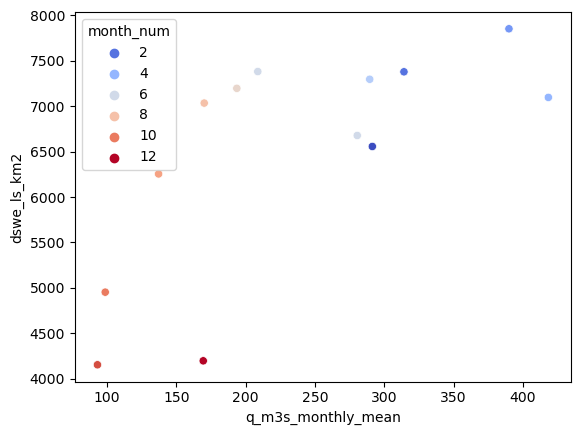

In [12]:
import seaborn as sns
sns.scatterplot(data = df_combined.query("(year == 2016 and month_num > 5) or (year == 2017 and month_num < 7)"),
                x = 'q_m3s_monthly_mean', y ='dswe_ls_km2',
               hue = 'month_num' , palette = 'coolwarm')

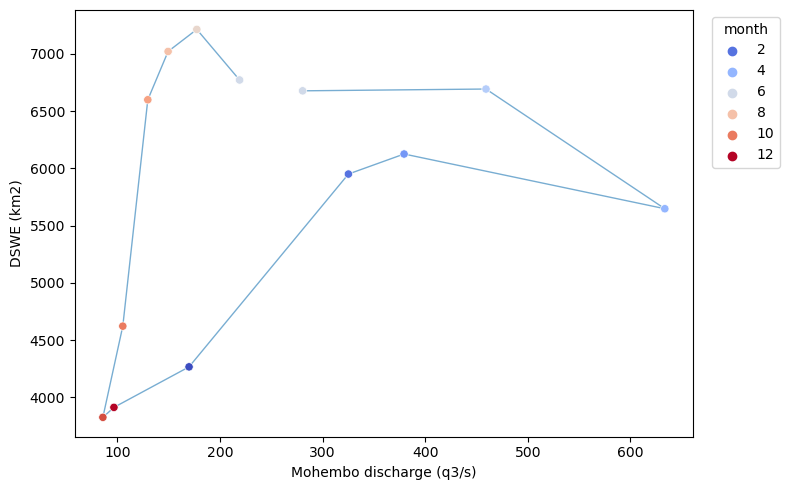

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

# Filter
dfp = df_combined.query(
    "(year == 2015 and month_num > 5) or (year == 2016 and month_num < 7)"
).copy()

# Make sure points connect in chronological order
# If your datetime index is the month (as in your screenshot), this is best:
if dfp.index.name == "month" or str(dfp.index.dtype).startswith("datetime"):
    dfp = dfp.sort_index()
else:
    dfp = dfp.sort_values(["year", "month_num"])

# Drop missing x/y so the line doesn't error
dfp = dfp.dropna(subset=["q_mm_month_delta", "dswe_ls_km2"])

fig, ax = plt.subplots(figsize=(8, 5))

# 1) Draw the connecting line (single path through time)
ax.plot(
    dfp["q_m3s_monthly_mean"],
    dfp["dswe_ls_km2"],
    marker="o",
    linewidth=1,
    markersize=3,
    alpha=0.6,
    zorder=1
)

# 2) Draw the colored scatter on top
sns.scatterplot(
    data=dfp,
    x="q_m3s_monthly_mean",
    y="dswe_ls_km2",
    hue="month_num",
    palette="coolwarm",
    ax=ax,
    zorder=2
)

ax.set_xlabel("Mohembo discharge (q3/s)")
ax.set_ylabel("DSWE (km2)")
ax.legend(title="month", bbox_to_anchor=(1.02, 1), loc="upper left")
plt.tight_layout()
plt.show()


In [14]:
import os
def plot_phase_by_water_year(
    df_combined,
    x="q_m3s_monthly_mean",
    y="dswe_ls_km2",
    year_col="year",
    month_col="month_num",
    wy_start_month=7,      # Jul–Jun by default; set to 6 for Jun–May, 10 for Oct–Sep, etc.
    wy_label="ending",     # "ending": Jul 2015–Jun 2016 => WY2016
    palette="coolwarm",
    outdir="wy_phaseplots",
    show=False,
    min_points=6
):
    df = df_combined.copy()

    # --- month normalization (handles 0–11 or 1–12) ---
    m = df[month_col].astype(int)
    if m.min() == 0:
        m = m + 1
    df["_month"] = m
    df["_year"] = df[year_col].astype(int)

    # --- datetime for sorting ---
    if isinstance(df.index, pd.DatetimeIndex):
        df["_dt"] = df.index
        df["_month"] = df.index.month
        df["_year"] = df.index.year
    else:
        df["_dt"] = pd.to_datetime(dict(year=df["_year"], month=df["_month"], day=1))

    # --- water year assignment ---
    if wy_label == "ending":
        # months >= start_month belong to next WY
        df["water_year"] = df["_year"] + (df["_month"] >= wy_start_month).astype(int)
    elif wy_label == "starting":
        # months < start_month belong to previous WY
        df["water_year"] = df["_year"] - (df["_month"] < wy_start_month).astype(int)
    else:
        raise ValueError("wy_label must be 'ending' or 'starting'")

    # --- clean + sort ---
    df = df.dropna(subset=[x, y]).sort_values("_dt")

    # --- output dir ---
    if outdir is not None:
        os.makedirs(outdir, exist_ok=True)

    for wy, dfp in df.groupby("water_year", sort=True):
        if len(dfp) < min_points:
            continue

        fig, ax = plt.subplots(figsize=(8, 5))

        # connecting line through time
        ax.plot(
            dfp[x], dfp[y],
            marker="o", linewidth=1, markersize=3, alpha=0.6, zorder=1
        )

        # colored scatter on top
        sns.scatterplot(
            data=dfp, x=x, y=y,
            hue="_month", palette=palette,
            ax=ax, zorder=2
        )

        ax.set_title(f"Water Year {wy} (start month = {wy_start_month})")
        ax.set_xlabel("Mohembo discharge (m$^3$/s)")  # change label if needed
        ax.set_ylabel("DSWE (km$^2$)")
        ax.legend(title="month", bbox_to_anchor=(1.02, 1), loc="upper left")
        fig.tight_layout()

        if outdir is not None:
            fig.savefig(f"{outdir}/phaseplot_WY{wy}.png", dpi=200, bbox_inches="tight")

        if show:
            plt.show()
        else:
            plt.close(fig)

# Example: July–June water years (WY labeled by ending year)
plot_phase_by_water_year(df_combined, wy_start_month=7, wy_label="ending", outdir="wy_phaseplots", show=False)
print("Saved to ./wy_phaseplots/")


Saved to ./wy_phaseplots/


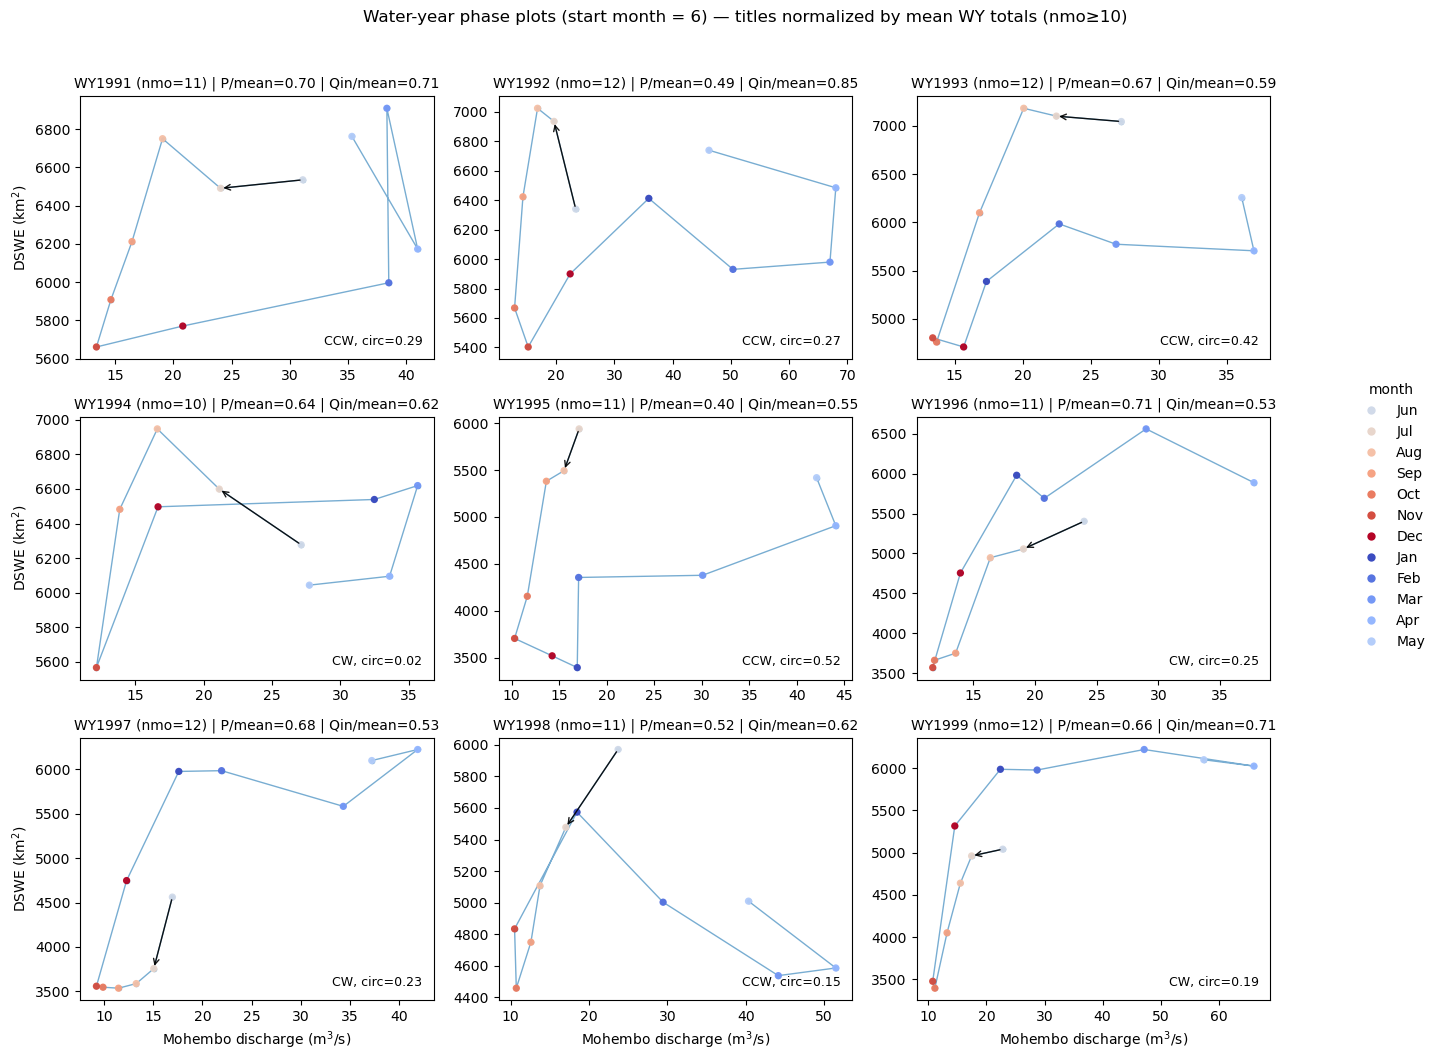

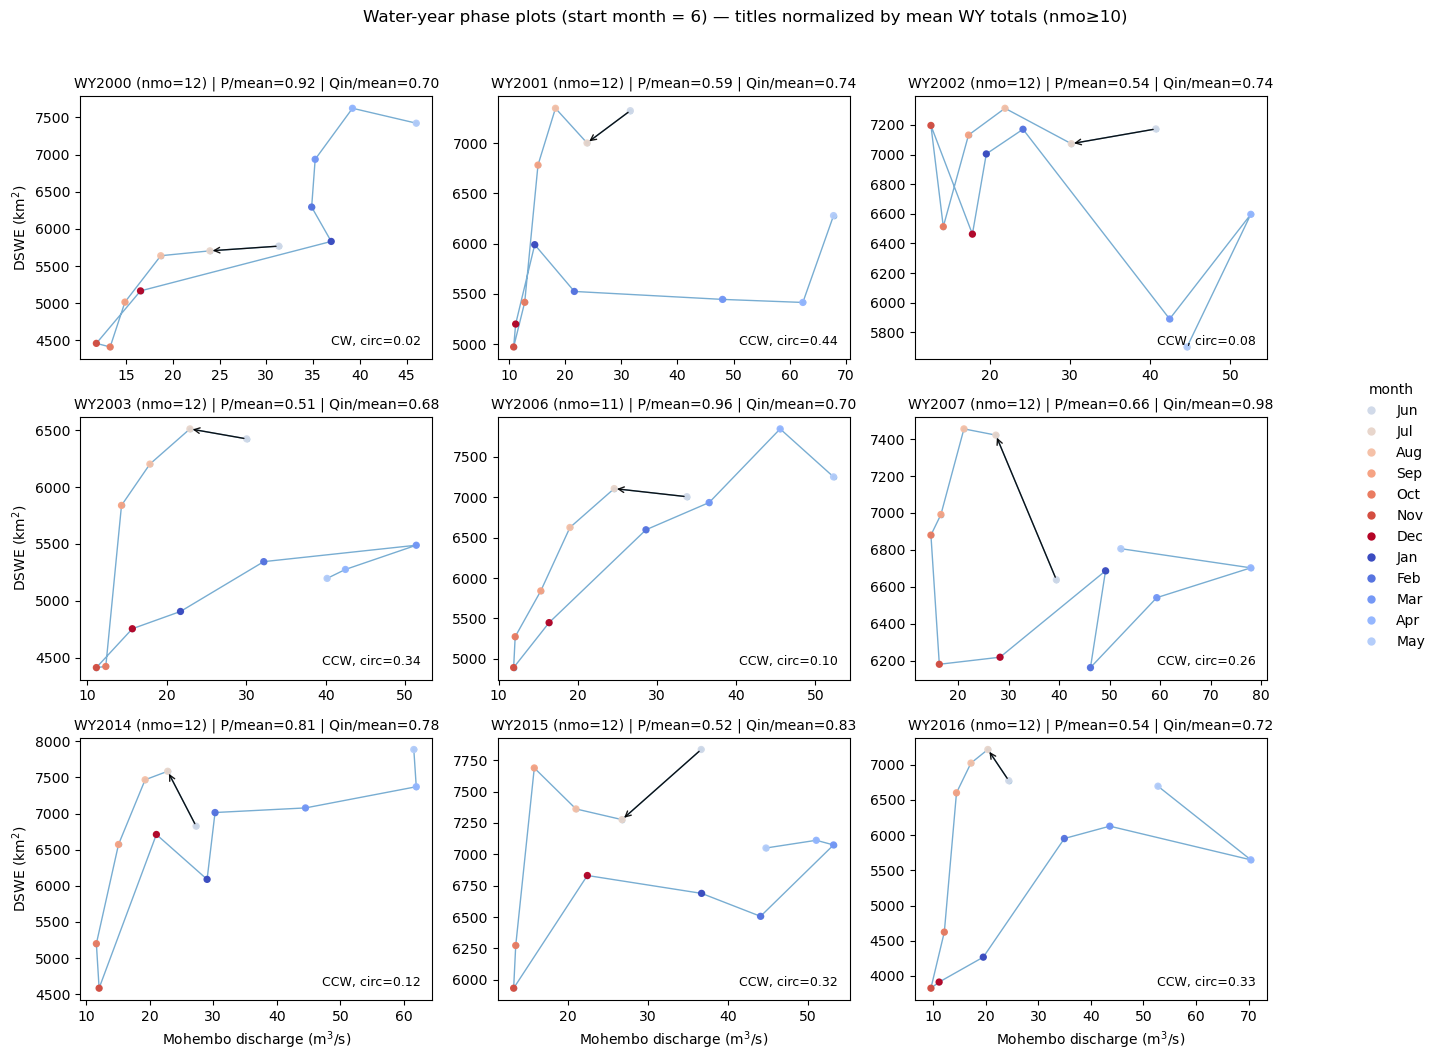

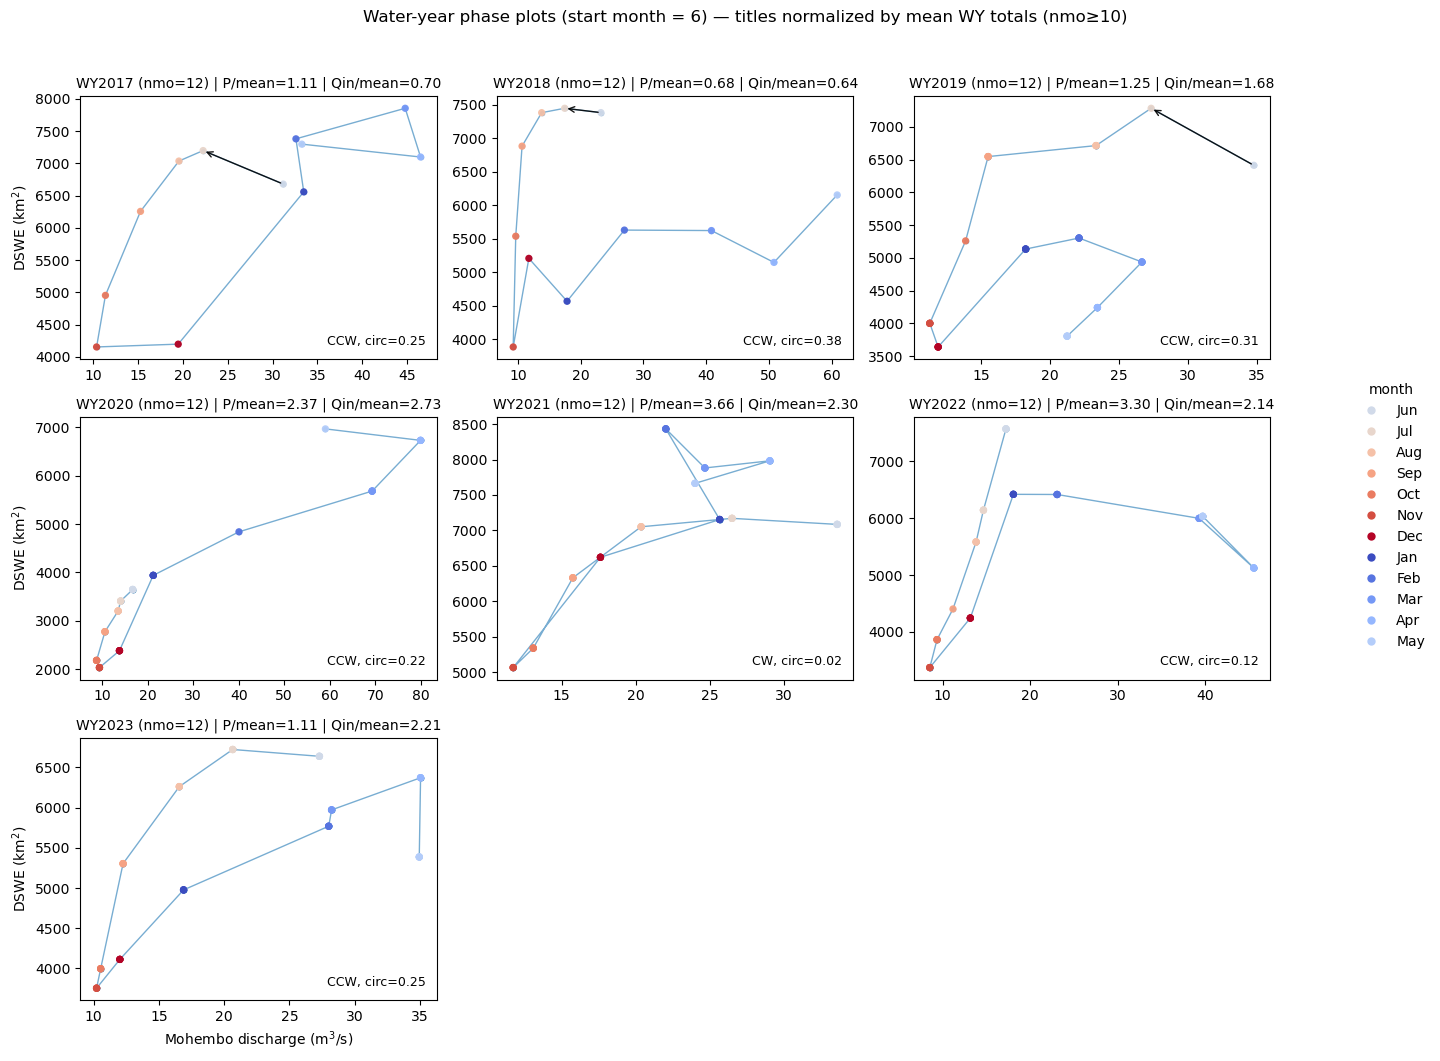

Saved 3 figure(s) to: wy_phaseplots_3x3/


In [15]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

def _loop_direction_and_circularity(xv, yv, normalize=True):
    """
    Direction: CW/CCW from signed area of the closed polyline (shoelace).
    Circularity: 4*pi*A / P^2 on (optionally) normalized x/y, in [0,1].
    """
    x = np.asarray(xv, dtype=float)
    y = np.asarray(yv, dtype=float)

    ok = np.isfinite(x) & np.isfinite(y)
    x, y = x[ok], y[ok]
    if len(x) < 3:
        return "NA", np.nan

    if normalize:
        xr = np.nanmax(x) - np.nanmin(x)
        yr = np.nanmax(y) - np.nanmin(y)
        if xr > 0:
            x = (x - np.nanmin(x)) / xr
        if yr > 0:
            y = (y - np.nanmin(y)) / yr

    # close the loop
    x2 = np.r_[x, x[0]]
    y2 = np.r_[y, y[0]]

    # signed area
    area = 0.5 * np.sum(x2[:-1] * y2[1:] - x2[1:] * y2[:-1])

    # perimeter
    perim = np.sum(np.hypot(np.diff(x2), np.diff(y2)))

    direction = "CCW" if area > 0 else ("CW" if area < 0 else "NA")
    circ = np.nan if perim <= 0 else float(np.clip(4 * np.pi * abs(area) / (perim ** 2), 0, 1))
    return direction, circ


def phaseplots_wy_grid(
    df_combined,
    x="q_mm_month_delta",
    y="dswe_ls_km2",
    year_col="year",
    month_col="month_num",
    wy_start_month=7,          # Jul–Jun water year
    wy_label="ending",         # "ending": Jul 2015–Jun 2016 => WY2016
    cmap="coolwarm",
    nrows=3,
    ncols=3,
    figsize=(15, 11),
    outdir="wy_phaseplots_3x3",
    dpi=200,
    show=True,

    # data completeness filters
    min_points=2,
    min_months=10,             # <-- ONLY plot WYs with >= this many months (with x & y present)

    xlabel="Mohembo discharge (m$^3$/s)",
    ylabel="DSWE (km$^2$)",

    # totals in titles (computed on full WY group; normalized by multi-year mean across INCLUDED WYs)
    precip_col=None,                    # e.g. "rain_delta_mm"
    inflow_col=None,                    # e.g. "q_m3s_monthly_mean"
    precip_label="P",
    inflow_label="Qin",
    precip_unit="mm",
    inflow_unit="mm",
    title_decimals=0,
    normalize_titles=True,
    norm_decimals=2,

    # hysteresis metrics
    add_loop_metrics=True,
    loop_metrics_normalize=True,        # normalize x/y before computing circularity
    loop_metrics_loc="lower right",
    loop_metrics_decimals=2,

    # arrow
    arrow_at="start",                   # "start" or "end"

    # month legend
    legend_month_names=True,
    legend_loc=(0.9, 0.5),              # figure coords
):
    df = df_combined.copy()

    # ---- build datetime + month/year robustly ----
    if isinstance(df.index, pd.DatetimeIndex):
        df["_dt"] = df.index
        df["_year"] = df.index.year.astype(int)
        df["_month"] = df.index.month.astype(int)
    else:
        df["_year"] = df[year_col].astype(int)
        m = df[month_col].astype(int)
        if m.min() == 0:  # handle 0–11
            m = m + 1
        df["_month"] = m
        df["_dt"] = pd.to_datetime(dict(year=df["_year"], month=df["_month"], day=1))

    # ---- water year assignment ----
    if wy_label == "ending":
        df["water_year"] = df["_year"] + (df["_month"] >= wy_start_month).astype(int)
    elif wy_label == "starting":
        df["water_year"] = df["_year"] - (df["_month"] < wy_start_month).astype(int)
    else:
        raise ValueError("wy_label must be 'ending' or 'starting'")

    df = df.sort_values("_dt")

    # If no inflow_col given, default to x
    if inflow_col is None:
        inflow_col = x

    # ---- month colors + legend order ----
    cm = plt.get_cmap(cmap, 12)
    month_colors = {mm: cm(mm - 1) for mm in range(1, 13)}  # 1..12
    wy_month_order = list(range(wy_start_month, 13)) + list(range(1, wy_start_month))

    month_names = ["Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"]
    legend_labels = [month_names[m-1] if legend_month_names else str(m) for m in wy_month_order]
    legend_handles = [
        Line2D([0], [0], marker="o", linestyle="", markersize=6,
               markerfacecolor=month_colors[m], markeredgecolor="none")
        for m in wy_month_order
    ]

    # --- prebuild WY groups (apply >=10 months filter here) ---
    groups = []
    for wy, g_all in df.groupby("water_year", sort=True):
        g_all = g_all.sort_values("_dt")
        g_plot = g_all.dropna(subset=[x, y]).copy()

        # months that will actually be plotted
        nmo = int(g_plot["_dt"].dt.to_period("M").nunique())

        if (nmo >= min_months) and (len(g_plot) >= min_points):
            groups.append((int(wy), g_all, g_plot, nmo))

    if not groups:
        raise ValueError(
            f"No water years found with >= {min_months} months of x/y data (and >= {min_points} points)."
        )

    # ---- compute multi-year mean WY totals for normalization (across INCLUDED WYs) ----
    mean_p = None
    mean_q = None
    if normalize_titles:
        if (precip_col is not None) and (precip_col in df.columns):
            totals_p = [float(np.nansum(g_all[precip_col].to_numpy())) for (_, g_all, _, _) in groups]
            mean_p = float(np.nanmean(totals_p)) if len(totals_p) else None
            if mean_p == 0:
                mean_p = None

        if (inflow_col is not None) and (inflow_col in df.columns):
            totals_q = [float(np.nansum(g_all[inflow_col].to_numpy())) for (_, g_all, _, _) in groups]
            mean_q = float(np.nanmean(totals_q)) if len(totals_q) else None
            if mean_q == 0:
                mean_q = None

    os.makedirs(outdir, exist_ok=True)

    per_page = nrows * ncols
    pages = int(np.ceil(len(groups) / per_page))

    for p in range(pages):
        chunk = groups[p * per_page : (p + 1) * per_page]

        fig, axes = plt.subplots(nrows, ncols, figsize=figsize)
        axes = np.array(axes).ravel()

        for i, ax in enumerate(axes):
            if i >= len(chunk):
                ax.axis("off")
                continue

            wy, g_all, dfp, nmo = chunk[i]

            # ---- title parts ----
            parts = [f"WY{wy} (nmo={nmo})"]

            if (precip_col is not None) and (precip_col in g_all.columns):
                tot_p = float(np.nansum(g_all[precip_col].to_numpy()))
                if normalize_titles and (mean_p is not None):
                    parts.append(f"{precip_label}/mean={tot_p/mean_p:.{norm_decimals}f}")
                else:
                    parts.append(f"{precip_label}={tot_p:.{title_decimals}f} {precip_unit}")

            if (inflow_col is not None) and (inflow_col in g_all.columns):
                tot_q = float(np.nansum(g_all[inflow_col].to_numpy()))
                if normalize_titles and (mean_q is not None):
                    parts.append(f"{inflow_label}/mean={tot_q/mean_q:.{norm_decimals}f}")
                else:
                    parts.append(f"{inflow_label}={tot_q:.{title_decimals}f} {inflow_unit}")

            ax.set_title(" | ".join(parts), fontsize=10)

            # 1) connecting line through time
            ax.plot(
                dfp[x].to_numpy(),
                dfp[y].to_numpy(),
                marker="o",
                linewidth=1,
                markersize=3,
                alpha=0.6,
                zorder=1,
            )

            # 2) colored scatter on top (month as discrete colors)
            point_colors = [month_colors[int(m)] for m in dfp["_month"].to_numpy()]
            ax.scatter(
                dfp[x].to_numpy(),
                dfp[y].to_numpy(),
                c=point_colors,
                s=18,
                alpha=0.95,
                zorder=2,
            )

            # 3) direction arrow
            if len(dfp) >= 2:
                j = 0 if arrow_at == "start" else (len(dfp) - 2)
                ax.annotate(
                    "",
                    xy=(float(dfp[x].iloc[j + 1]), float(dfp[y].iloc[j + 1])),
                    xytext=(float(dfp[x].iloc[j]), float(dfp[y].iloc[j])),
                    arrowprops=dict(arrowstyle="->", lw=1, alpha=0.9),
                    zorder=3,
                )

            # 4) loop metrics text (per subplot)
            if add_loop_metrics:
                direction, circ = _loop_direction_and_circularity(
                    dfp[x].to_numpy(), dfp[y].to_numpy(), normalize=loop_metrics_normalize
                )
                metric_txt = (
                    f"{direction}, circ={circ:.{loop_metrics_decimals}f}"
                    if np.isfinite(circ) else f"{direction}, circ=NA"
                )
                dummy = Line2D([], [], linestyle="None")  # text-only legend
                ax.legend(
                    [dummy], [metric_txt],
                    loc=loop_metrics_loc,
                    frameon=False,
                    handlelength=0,
                    handletextpad=0,
                    fontsize=9,
                )

            # axis labels only on left + bottom
            r, c = divmod(i, ncols)
            ax.set_ylabel(ylabel if c == 0 else "")
            ax.set_xlabel(xlabel if r == nrows - 1 else "")

        # ---- figure-level month legend ----
        fig.legend(
            legend_handles,
            legend_labels,
            title="month",
            loc="center left",
            bbox_to_anchor=legend_loc,
            frameon=False,
        )

        fig.suptitle(
            f"Water-year phase plots (start month = {wy_start_month})"
            + (f" — titles normalized by mean WY totals (nmo≥{min_months})" if normalize_titles else ""),
            y=0.96,
            fontsize=12,
        )

        # leave room for the month legend on the right
        fig.tight_layout(rect=[0, 0, 0.86, 0.94])

        outpath = os.path.join(outdir, f"phaseplots_WY_page{p+1:02d}.png")
        fig.savefig(outpath, dpi=dpi, bbox_inches="tight")

        if show:
            plt.show()
        else:
            plt.close(fig)

    print(f"Saved {pages} figure(s) to: {outdir}/")


# Example:
phaseplots_wy_grid(
    df_combined,
    wy_start_month=6,
    wy_label="ending",
    precip_col="rain_delta_mm",
    inflow_col="q_m3s_monthly_mean",
    min_months=10,
    normalize_titles=True,
    arrow_at="start",
    show=True
)


In [16]:
df_combined.head()

,q_m3s_monthly_mean,rain_delta_mm,rain_highlands_mm,cygnss_km2,dswe_ls_km2,dswe_s2_km2,year,month_num,q_mm_month_delta
month,,,,,,,,,
1990-01-01,144.700968,120.255636,324.201135,NaN,NaN,NaN,1990,1,16.621634
1990-02-01,270.588929,79.864579,115.790675,NaN,4933.546789,NaN,1990,2,28.074280
1990-03-01,395.561613,44.176758,136.100929,NaN,5010.307595,NaN,1990,3,45.437707
1990-04-01,419.280667,26.840830,86.174812,NaN,5617.024101,NaN,1990,4,46.608665
1990-05-01,470.686452,0.000000,0.000000,NaN,6352.790231,NaN,1990,5,54.067211


In [17]:
def compile_wy_metrics(
    df_combined,
    x="q_mm_month_delta",
    y="dswe_ls_km2",
    year_col="year",
    month_col="month_num",
    wy_start_month=1,
    wy_label="ending",              # "ending" (Jul–Jun => WY end year) or "starting"
    precip_col=None,                # e.g. "rain_delta_mm"
    inflow_col=None,                # e.g. "q_m3s_monthly_mean" (or None -> use x)
    loop_metrics_normalize=True,
    min_points=2,                   # match plotting filter
    add_prior_wy=True,
    prior_wy_lag=1                  # 1 = previous WY
    ):
    df = df_combined.copy()

    # ---- build datetime + month/year robustly ----
    if isinstance(df.index, pd.DatetimeIndex):
        df["_dt"] = df.index
        df["_year"] = df.index.year.astype(int)
        df["_month"] = df.index.month.astype(int)
    else:
        df["_year"] = df[year_col].astype(int)
        m = df[month_col].astype(int)
        if m.min() == 0:  # handle 0–11
            m = m + 1
        df["_month"] = m
        df["_dt"] = pd.to_datetime(dict(year=df["_year"], month=df["_month"], day=1))

    # ---- water year assignment ----
    if wy_label == "ending":
        # special-case wy_start_month=1 => Jan–Dec ends in same calendar year
        if int(wy_start_month) == 1:
            df["water_year"] = df["_year"]
        else:
            df["water_year"] = df["_year"] + (df["_month"] >= wy_start_month).astype(int)
    elif wy_label == "starting":
        df["water_year"] = df["_year"] - (df["_month"] < wy_start_month).astype(int)
    else:
        raise ValueError("wy_label must be 'ending' or 'starting'")

    df = df.sort_values("_dt")

    if inflow_col is None:
        inflow_col = x

    # ---- helper: sum but return NaN if all values are NaN ----
    def _nansum_or_nan(s):
        s = pd.to_numeric(s, errors="coerce")
        return np.nan if s.isna().all() else float(np.nansum(s.to_numpy()))

    # ---- WY totals for ALL years (even those that won't pass min_points) ----
    totals_rows = []
    for wy, g in df.groupby("water_year", sort=True):
        tot_p = np.nan
        if (precip_col is not None) and (precip_col in g.columns):
            tot_p = _nansum_or_nan(g[precip_col])

        tot_q = np.nan
        if (inflow_col is not None) and (inflow_col in g.columns):
            tot_q = _nansum_or_nan(g[inflow_col])

        totals_rows.append({"water_year": int(wy), "precip_total": tot_p, "inflow_total": tot_q})

    wy_totals = pd.DataFrame(totals_rows).sort_values("water_year").reset_index(drop=True)

    # lagged totals to merge onto kept WYs
    wy_totals_prev = wy_totals.rename(
        columns={"precip_total": "precip_total_prev", "inflow_total": "inflow_total_prev"}
    ).copy()
    wy_totals_prev["water_year"] = wy_totals_prev["water_year"] + int(prior_wy_lag)

    # ---- compute loop metrics only for WYs with enough x/y points ----
    rows = []
    for wy, g_all in df.groupby("water_year", sort=True):
        g_all = g_all.sort_values("_dt")

        g_xy = g_all.dropna(subset=[x, y]).copy()
        if len(g_xy) < min_points:
            continue

        n_months_xy = int(g_xy["_dt"].dt.to_period("M").nunique())
        n_points_xy = int(len(g_xy))

        direction, circularity = _loop_direction_and_circularity(
            g_xy[x].to_numpy(), g_xy[y].to_numpy(), normalize=loop_metrics_normalize
        )

        # totals from WY totals table (consistent + available for all WYs)
        tot_row = wy_totals.loc[wy_totals["water_year"] == int(wy)]
        tot_p = float(tot_row["precip_total"].iloc[0]) if len(tot_row) else np.nan
        tot_q = float(tot_row["inflow_total"].iloc[0]) if len(tot_row) else np.nan

        rows.append({
            "water_year": int(wy),
            "wy_start_month": int(wy_start_month),
            "wy_label": wy_label,
            "n_months_xy": n_months_xy,
            "n_points_xy": n_points_xy,
            "precip_total": tot_p,
            "inflow_total": tot_q,
            "loop_direction": direction,
            "loop_circularity": circularity,
        })

    metrics = pd.DataFrame(rows).sort_values("water_year").reset_index(drop=True)

    # ---- attach prior WY totals ----
    if add_prior_wy:
        metrics = metrics.merge(wy_totals_prev, on="water_year", how="left")
    else:
        metrics["precip_total_prev"] = np.nan
        metrics["inflow_total_prev"] = np.nan

    # ---- normalization by multi-year mean WY totals ----
    if precip_col is not None and metrics["precip_total"].notna().any():
        p_mean = metrics["precip_total"].mean(skipna=True)
        metrics["precip_total_mean"] = p_mean
        metrics["precip_norm"] = metrics["precip_total"] / p_mean if (p_mean != 0 and np.isfinite(p_mean)) else np.nan
        metrics["precip_norm_prev"] = (
            metrics["precip_total_prev"] / p_mean if (p_mean != 0 and np.isfinite(p_mean)) else np.nan
        )
    else:
        metrics["precip_total_mean"] = np.nan
        metrics["precip_norm"] = np.nan
        metrics["precip_norm_prev"] = np.nan

    if inflow_col is not None and metrics["inflow_total"].notna().any():
        q_mean = metrics["inflow_total"].mean(skipna=True)
        metrics["inflow_total_mean"] = q_mean
        metrics["inflow_norm"] = metrics["inflow_total"] / q_mean if (q_mean != 0 and np.isfinite(q_mean)) else np.nan
        metrics["inflow_norm_prev"] = (
            metrics["inflow_total_prev"] / q_mean if (q_mean != 0 and np.isfinite(q_mean)) else np.nan
        )
    else:
        metrics["inflow_total_mean"] = np.nan
        metrics["inflow_norm"] = np.nan
        metrics["inflow_norm_prev"] = np.nan

    return metrics

wy_metrics = compile_wy_metrics(
    df_combined,
    wy_start_month=2,
    wy_label="ending",
    precip_col="rain_delta_mm",
    inflow_col="q_m3s_monthly_mean",
    x="q_mm_month_delta",
    y="dswe_ls_km2",
    min_points=2,
    loop_metrics_normalize=True,
    add_prior_wy=True,
    prior_wy_lag=1
)

wy_metrics["total_input"] = wy_metrics["inflow_norm"]*2 + wy_metrics["precip_norm"]
wy_metrics["total_input_prev"] = wy_metrics["inflow_norm_prev"]*2 + wy_metrics["precip_norm_prev"]

In [18]:
wy_metrics.sort_values("precip_total")

,water_year,wy_start_month,wy_label,n_months_xy,n_points_xy,precip_total,inflow_total,loop_direction,loop_circularity,precip_total_prev,inflow_total_prev,precip_total_mean,precip_norm,precip_norm_prev,inflow_total_mean,inflow_norm,inflow_norm_prev,total_input,total_input_prev
4,1995,2,ending,10,10,261.392347,2231.950111,CCW,0.457229,523.437656,2444.799071,700.893818,0.372941,0.746814,4009.585318,0.556654,0.609739,1.486249,1.966292
23,2016,2,ending,12,12,327.637121,2871.897413,CCW,0.465725,495.552661,3409.138515,700.893818,0.467456,0.707030,4009.585318,0.716258,0.850247,1.899972,2.407524
12,2003,2,ending,12,12,336.957587,2749.240598,CCW,0.034432,550.402458,3318.210929,700.893818,0.480754,0.785287,4009.585318,0.685667,0.827570,1.852088,2.440426
2,1993,2,ending,12,12,363.917596,3359.639872,CCW,0.431993,495.159494,2791.538653,700.893818,0.519219,0.706469,4009.585318,0.837902,0.696216,2.195023,2.098901
21,2014,2,ending,11,11,374.575584,3230.088999,CCW,0.228964,475.981521,3938.283784,700.893818,0.534426,0.679106,4009.585318,0.805592,0.982217,2.145609,2.643541
13,2004,2,ending,7,7,390.753175,3028.489087,CW,0.049680,336.957587,2749.240598,700.893818,0.557507,0.480754,4009.585318,0.755312,0.685667,2.068132,1.852088
0,1991,2,ending,11,11,390.902231,3052.279230,CCW,0.623872,120.255636,144.700968,700.893818,0.557720,0.171575,4009.585318,0.761246,0.036089,2.080211,0.243752
8,1999,2,ending,12,12,401.428791,2608.332317,CW,0.061839,442.787486,2253.878031,700.893818,0.572738,0.631747,4009.585318,0.650524,0.562122,1.873787,1.755992
5,1996,2,ending,12,12,407.330700,2327.891720,CCW,0.161540,261.392347,2231.950111,700.893818,0.581159,0.372941,4009.585318,0.580582,0.556654,1.742322,1.486249
7,1998,2,ending,11,11,442.787486,2253.878031,CCW,0.066430,538.605534,1958.624051,700.893818,0.631747,0.768455,4009.585318,0.562122,0.488485,1.755992,1.745426


In [19]:
wy_metrics['inflow_norm'].std(), wy_metrics['precip_norm'].std()

(0.6322460381063596, 0.7480838960502689)

In [20]:
wy_metrics.query("loop_direction == 'CCW' and n_months_xy > 10")[['precip_norm', 
        'precip_norm_prev', 'inflow_norm', 'inflow_norm_prev',  'loop_circularity']].corr().round(2)

# Can we do better if we include 

,precip_norm,precip_norm_prev,inflow_norm,inflow_norm_prev,loop_circularity
precip_norm,1.00,0.77,0.93,0.77,-0.21
precip_norm_prev,0.77,1.00,0.71,0.94,-0.32
inflow_norm,0.93,0.71,1.00,0.71,-0.12
inflow_norm_prev,0.77,0.94,0.71,1.00,-0.37
loop_circularity,-0.21,-0.32,-0.12,-0.37,1.00


Loop direction + circularity metrics for a hysteresis (x,y) phase loop

Given ordered points $(x_i, y_i)$, i = 1,...,N, close the polyline by setting
 $(x_{N+1}, y_{N+1}) = (x_1, y_1)$.

Per-loop normalization to reduce unit/aspect-ratio effects:
$
x_i=\frac{x_i-\min(x)}{\max(x)-\min(x)}, 
\qquad
y_i=\frac{y_i-\min(y)}{\max(y)-\min(y)}.
$

Signed area (shoelace formula):

$
A=\frac{1}{2}\sum_{i=1}^{N}\left(x_i\,y_{i+1}-x_{i+1}\,y_i\right).
$

Direction from the sign of A (standard Cartesian coordinates):
$
\text{direction} =
\begin{cases}
\mathrm{CCW}, & A>0,\\
\mathrm{CW},  & A<0,\\
\mathrm{NA},  & A=0.
\end{cases}
$

Perimeter (path length of the closed polyline):
$
P=\sum_{i=1}^{N}\sqrt{\left(x_{i+1}-x_i\right)^2+\left(y_{i+1}-y_i\right)^2}.
$

Circularity (dimensionless; equals 1 for a perfect circle):
$
\mathcal{C}=\frac{4\pi |A|}{P^2}, \qquad 0 \le \mathcal{C} \le 1.
$


In [21]:
# subset[['loop_circularity', 'inflow_norm']].corr()

Text(0, 0.5, 'hysteresis')

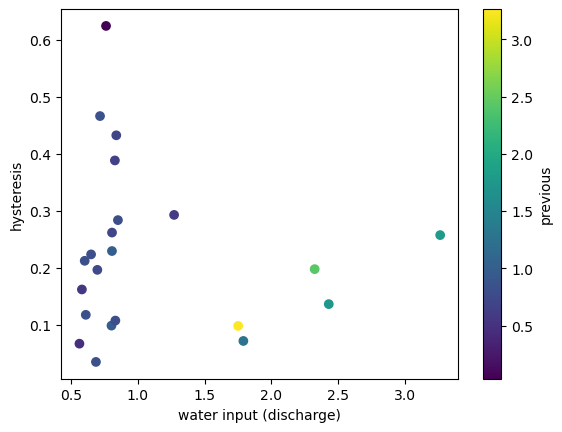

In [22]:

subset = wy_metrics.query("loop_direction == 'CCW' and n_months_xy > 10")
plt.scatter(subset['inflow_norm'], subset['loop_circularity'], 
            c = subset['inflow_norm_prev'])
plt.colorbar(label = 'previous')
plt.xlabel("water input (discharge)")
plt.ylabel("hysteresis")


Text(0, 0.5, 'hysteresis')

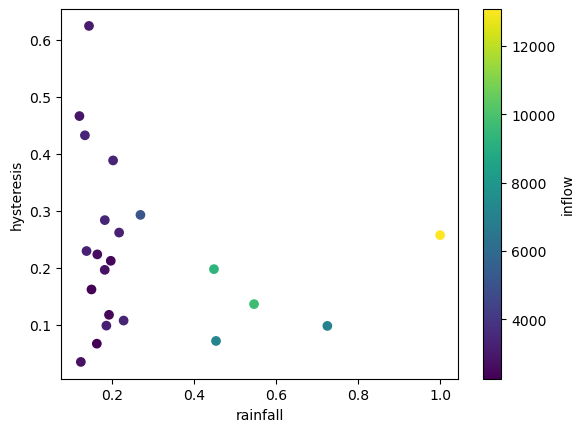

In [23]:
subset = wy_metrics.query("loop_direction == 'CCW' and n_months_xy > 10")
plt.scatter(subset['precip_total']/subset['precip_total'].max(),subset['loop_circularity'], 
            c = subset['inflow_total'])
plt.colorbar(label = 'inflow')
plt.xlabel("rainfall")
plt.ylabel("hysteresis")

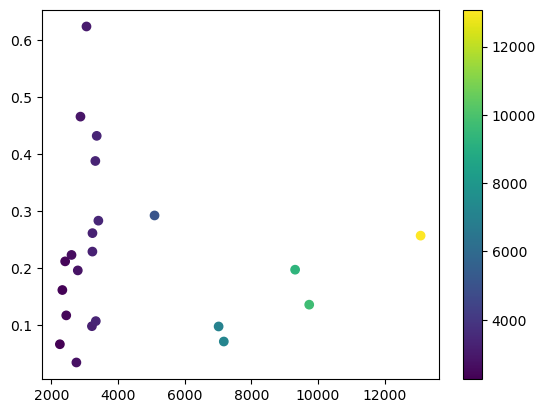

In [24]:
subset = wy_metrics.query("loop_direction == 'CCW' and n_months_xy > 10")
plt.scatter(subset['inflow_total'],subset['loop_circularity'], c = subset['inflow_total'])
plt.colorbar()

In [25]:
from pathlib import Path
import geopandas as gpd
import matplotlib.pyplot as plt

delta_shp = Path("../data/regions/Delta_UCB_WGS84/Delta_UCB_WGS84.shp")
assert delta_shp.exists(), f"Not found: {delta_shp.resolve()}"

gdf = gpd.read_file(delta_shp)

# Ensure WGS84 (lon/lat) for sane bounds/labels
gdf = gdf.to_crs(epsg=4326)

print("CRS:", gdf.crs)
print("Bounds (minx, miny, maxx, maxy):", gdf.total_bounds)


CRS: EPSG:4326
Bounds (minx, miny, maxx, maxy): [ 21.79128644 -20.18578544  24.03322117 -18.26936169]


<Axes: xlabel='q_mm_month_delta', ylabel='rain_delta_mm'>

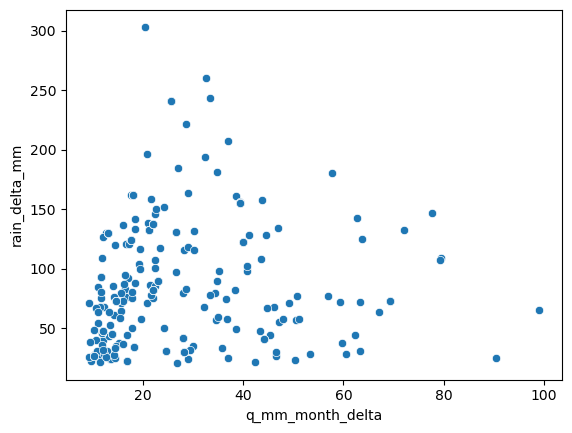

In [26]:
import seaborn as sns
sns.scatterplot(data = df_combined.query("rain_delta_mm > 20"), x = 'q_mm_month_delta', y ='rain_delta_mm')
# sns.scatterplot(data = df_combined, x = 'rain_delta_mm', y ='dswe_ls_km2')

In [27]:
#  Together predict flood extent a little better?
#  Read in GRACE.
#  Still need to fix the GRACE timeseries.
#  Maybe look at all GRACE grid cells separately as well. 


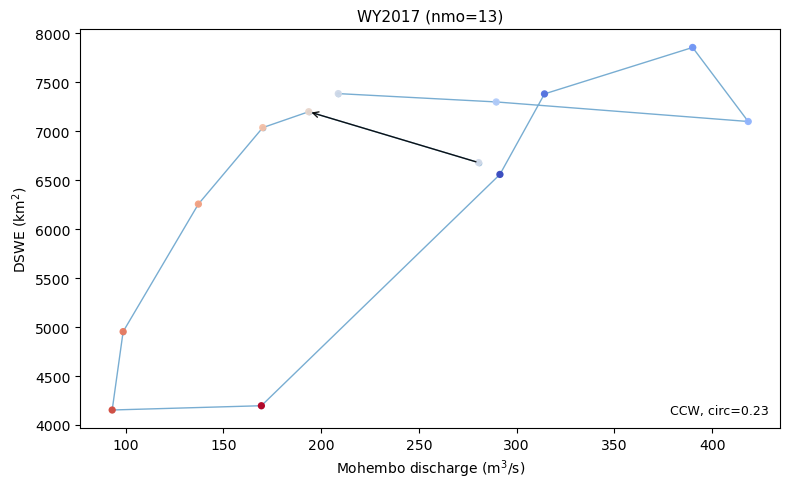

In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D


# --- match your filter ---
dfp = df_combined.query(
    "(year == 2016 and month_num > 5) or (year == 2017 and month_num < 7)"
).copy()

xcol = "q_m3s_monthly_mean"
ycol = "dswe_ls_km2"

# month normalization (handles 0–11 or 1–12)
m = dfp["month_num"].astype(int)
if m.min() == 0:
    m = m + 1
dfp["_month"] = m
dfp["_dt"] = pd.to_datetime(dict(year=dfp["year"].astype(int), month=dfp["_month"], day=1))

# sort + drop NA so the line/metrics behave
dfp = dfp.sort_values("_dt").dropna(subset=[xcol, ycol])

# --- styling to match 3x3 ---
wy_start_month = 7  # set to 6 if you want Jun–May, etc.

# discrete month colors
cm = plt.get_cmap("coolwarm", 12)
month_colors = {mm: cm(mm - 1) for mm in range(1, 13)}
point_colors = [month_colors[int(mm)] for mm in dfp["_month"].to_numpy()]

# legend order (water-year order)
wy_month_order = list(range(wy_start_month, 13)) + list(range(1, wy_start_month))
month_names = ["Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"]
months_present = set(dfp["_month"].unique().tolist())

legend_handles = [
    Line2D([0], [0], marker="o", linestyle="", markersize=6,
           markerfacecolor=month_colors[m], markeredgecolor="none")
    for m in wy_month_order if m in months_present
]
legend_labels = [
    month_names[m-1] for m in wy_month_order if m in months_present
]

# water-year label (ending year convention)
dfp["water_year"] = dfp["_dt"].dt.year + (dfp["_month"] >= wy_start_month).astype(int)
wy = int(dfp["water_year"].mode().iloc[0])
nmo = int(dfp["_dt"].dt.to_period("M").nunique())

# loop metrics
direction, circ = _loop_direction_and_circularity(dfp[xcol], dfp[ycol], normalize=True)
loop_txt = f"{direction}, circ={circ:.2f}" if np.isfinite(circ) else f"{direction}, circ=NA"

# --- plot ---
fig, ax = plt.subplots(figsize=(8, 5))

# connecting line
ax.plot(
    dfp[xcol].to_numpy(),
    dfp[ycol].to_numpy(),
    marker="o",
    linewidth=1,
    markersize=3,
    alpha=0.6,
    zorder=1,
)

# colored points
ax.scatter(
    dfp[xcol].to_numpy(),
    dfp[ycol].to_numpy(),
    c=point_colors,
    s=18,
    alpha=0.95,
    zorder=2,
)

# direction arrow (first segment; switch to len(dfp)-2 for end)
if len(dfp) >= 2:
    j = 0
    ax.annotate(
        "",
        xy=(float(dfp[xcol].iloc[j+1]), float(dfp[ycol].iloc[j+1])),
        xytext=(float(dfp[xcol].iloc[j]), float(dfp[ycol].iloc[j])),
        arrowprops=dict(arrowstyle="->", lw=1, alpha=0.9),
        zorder=3,
    )

# labels + title
ax.set_xlabel("Mohembo discharge (m$^3$/s)")
ax.set_ylabel("DSWE (km$^2$)")
ax.set_title(f"WY{wy} (nmo={nmo})", fontsize=11)

# month legend (outside) + loop metrics (inside)
leg_month = ax.legend(
    legend_handles, legend_labels,
    title="month",
    bbox_to_anchor=(1.02, 1),
    loc="upper left",
    frameon=False,
)
ax.add_artist(leg_month)

dummy = Line2D([], [], linestyle="None")
ax.legend(
    [dummy], [loop_txt],
    loc="lower right",
    frameon=False,
    handlelength=0,
    handletextpad=0,
    fontsize=9,
)

plt.tight_layout()
plt.show()


In [29]:
from pathlib import Path
import geopandas as gpd
import folium

delta_shp = Path("../data/regions/Delta_UCB_WGS84/Delta_UCB_WGS84.shp")
gdf = gpd.read_file(delta_shp).to_crs(epsg=4326)

# Center the map on the polygon
centroid = gdf.unary_union.centroid
m = folium.Map(location=[centroid.y, centroid.x], zoom_start=8, tiles=None)

# Basemaps (pick what you like)
folium.TileLayer("OpenStreetMap", name="OpenStreetMap").add_to(m)
folium.TileLayer("CartoDB positron", name="Carto Positron").add_to(m)
folium.TileLayer(
    tiles="https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}",
    attr="Esri",
    name="Esri World Imagery",
    overlay=False,
    control=True,
).add_to(m)

# Add polygon overlay
geojson = gdf.__geo_interface__
folium.GeoJson(
    geojson,
    name="Delta polygon",
    style_function=lambda feat: {
        "color": "yellow",
        "weight": 3,
        "fillColor": "yellow",
        "fillOpacity": 0.1,
    },
).add_to(m)

folium.LayerControl(collapsed=False).add_to(m)

# If your notebook can't render folium inline, save and open the HTML.
# out = "delta_basemap.html"
# m.save(out)
# print(f"Saved {out}")

m


In [30]:
# c/69703c66-1370-8325-9760-83f92c174b84

In [31]:
# --- Plot the Delta shapefile on a folium basemap + (optional) compute monthly ET over the Delta in EE ---

from pathlib import Path
import pandas as pd
import geopandas as gpd
import folium

import ee
from IPython.display import display

# -------------------------
# CONFIG
# -------------------------
delta_shp = Path("../data/regions/Delta_UCB_WGS84/Delta_UCB_WGS84.shp")
assert delta_shp.exists(), f"Not found: {delta_shp.resolve()}"

START = "2000-01-01"  # set to "2012-01-01" if you want faster
# Use first day of next month so there is ALWAYS at least one full monthly bin
END = (pd.Timestamp.today().normalize() + pd.offsets.MonthBegin(1)).strftime("%Y-%m-%d")

# Toggle ET computation (folium-only vs folium + EE)
RUN_EE_ET = True

# -------------------------
# 1) Load shapefile (WGS84) + folium basemap
# -------------------------
gdf = gpd.read_file(delta_shp).to_crs(epsg=4326)
if gdf.empty:
    raise ValueError(f"Shapefile has no features: {delta_shp}")

delta_union = gdf.unary_union
centroid = delta_union.centroid

m = folium.Map(location=[centroid.y, centroid.x], zoom_start=8, tiles=None)

folium.TileLayer("OpenStreetMap", name="OpenStreetMap").add_to(m)
folium.TileLayer("CartoDB positron", name="Carto Positron").add_to(m)
folium.TileLayer(
    tiles="https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}",
    attr="Esri",
    name="Esri World Imagery",
    overlay=False,
    control=True,
).add_to(m)

folium.GeoJson(
    gdf.__geo_interface__,
    name="Delta polygon",
    style_function=lambda feat: {
        "color": "yellow",
        "weight": 3,
        "fillColor": "yellow",
        "fillOpacity": 0.1,
    },
).add_to(m)

folium.LayerControl(collapsed=False).add_to(m)

display(m)

# -------------------------
# 2) (Optional) Earth Engine monthly ET sums over the Delta
# # -------------------------
# if RUN_EE_ET:
#     # ee.Authenticate()  # run once per environment if needed
#     ee.Initialize()

#     delta_geom = ee.Geometry(delta_union.__geo_interface__)
#     delta_area_m2 = delta_geom.area(maxError=1)

#     def monthly_sequence(start_date: str, end_date: str) -> ee.List:
#         """Month offsets [0..n-1] from start to end (end exclusive)."""
#         start = ee.Date(start_date)
#         end = ee.Date(end_date)
#         n_months = end.difference(start, "month").toInt()
#         return ee.List.sequence(0, n_months.subtract(1))

#     def make_monthly_et_ic(ic: ee.ImageCollection, to_mm_fn, start_date: str, end_date: str) -> ee.ImageCollection:
#         """
#         Monthly ImageCollection with band 'et_mm' (mm/month) via summing inputs in each month.
#         Safe when (start,end) yields zero months.
#         """
#         start = ee.Date(start_date)
#         end = ee.Date(end_date)
#         n_months = end.difference(start, "month").toInt()

#         def month_img(m):
#             m = ee.Number(m)
#             m0 = start.advance(m, "month")
#             m1 = m0.advance(1, "month")
#             sub = ic.filterDate(m0, m1).map(to_mm_fn)

#             mm = ee.Image(ee.Algorithms.If(sub.size().gt(1), sub.sum(), ee.Image.constant(0)))
#             return (mm.rename("et_mm")
#                       .set({"system:time_start": m0.millis(), "ym": m0.format("YYYY-MM")}))

#         months = ee.List(ee.Algorithms.If(n_months.gt(0), monthly_sequence(start_date, end_date), ee.List([])))
#         return ee.ImageCollection.fromImages(months.map(month_img))

#     def monthly_region_stats(monthly_ic: ee.ImageCollection, dataset_name: str,
#                              region: ee.Geometry, area_m2: ee.Number, scale_m: int) -> pd.DataFrame:
#         """
#         For each monthly image (band et_mm), compute:
#           - mean ET depth over polygon (mm/month)
#           - total ET volume (km^3/month)
#         Safe when monthly_ic is empty.
#         """
#         def img_to_feat(img):
#             img = ee.Image(img)
#             date = ee.Date(img.get("system:time_start"))

#             et_mm = img.select("et_mm").unmask(0)
#             et_m3 = et_mm.divide(1000).multiply(ee.Image.pixelArea()).rename("et_m3")

#             total_m3 = ee.Number(
#                 et_m3.reduceRegion(
#                     reducer=ee.Reducer.sum(),
#                     geometry=region,
#                     scale=scale_m,
#                     maxPixels=1e13,
#                     tileScale=4
#                 ).get("et_m3")
#             )
#             mean_mm = total_m3.divide(area_m2).multiply(1000)

#             return ee.Feature(None, {
#                 "dataset": dataset_name,
#                 "date": date.format("YYYY-MM-dd"),
#                 "et_mm_mean": mean_mm,
#                 "et_km3_total": total_m3.divide(1e9)
#             })

#         n = monthly_ic.size()
#         img_list = ee.List(ee.Algorithms.If(n.gt(0), monthly_ic.toList(n), ee.List([])))
#         fc = ee.FeatureCollection(img_list.map(img_to_feat))

#         info = fc.getInfo()
#         feats = info.get("features", [])
#         rows = [f["properties"] for f in feats]

#         df = pd.DataFrame(rows)
#         if df.empty:
#             return pd.DataFrame(columns=["dataset", "date", "et_mm_mean", "et_km3_total"])

#         df["date"] = pd.to_datetime(df["date"])
#         return df.sort_values("date").reset_index(drop=True)

#     # --- Converters to mm per native timestep (then monthly sum happens upstream)
#     def mod16_mm(img):
#         # ET is kg/m^2 per composite period; scale 0.1 => mm per composite period
#         return img.select("ET").multiply(0.1)

#     def terraclimate_mm(img):
#         # aet is mm with scale 0.1 => mm/month
#         return img.select("aet").multiply(0.1)

#     def fldas_mm(img):
#         # Evap_tavg is kg/m^2/s (monthly mean flux); integrate over month => kg/m^2 (mm)
#         d0 = ee.Date(img.get("system:time_start"))
#         seconds = d0.advance(1, "month").difference(d0, "second")
#         return img.select("Evap_tavg").multiply(seconds)

#     def era5_land_mm(img):
#         # total_evaporation_sum is meters of water equiv; negative = evaporation
#         return img.select("total_evaporation_sum").multiply(-1000)

#     def pml_mm(img):
#         # Components are mm/day; approximate 8-day composite => mm per image
#         et_mmday = img.select(["Ec", "Es", "Ei"]).reduce(ee.Reducer.sum())
#         return et_mmday.multiply(8)

#     def wapor_mm(img):
#         # L1-AETI-D is avg daily mm/day in dekad (scale 0.1). Convert to mm/dekad via dekad length.
#         d0 = ee.Date(img.get("system:time_start"))
#         d1_candidate = d0.advance(10, "day")
#         month_end = ee.Date.fromYMD(d0.get("year"), d0.get("month"), 1).advance(1, "month")
#         d1 = ee.Date(ee.Algorithms.If(d1_candidate.millis().lte(month_end.millis()), d1_candidate, month_end))
#         days = d1.difference(d0, "day")
#         return img.select("L1-AETI-D").multiply(0.1).multiply(days)

#     DATASETS = [
#         dict(name="MOD16A2GF_v61", id="MODIS/061/MOD16A2GF", to_mm=mod16_mm, scale=500,  start="2000-01-01"),
#         dict(name="MOD16A2_v61",   id="MODIS/061/MOD16A2",   to_mm=mod16_mm, scale=500,  start="2021-01-01"),
#         dict(name="PML_v2_landET", id="CAS/IGSNRR/PML/V2_v018", to_mm=pml_mm, scale=500, start="2000-01-01"),
#         dict(name="TerraClimate_aet", id="IDAHO_EPSCOR/TERRACLIMATE", to_mm=terraclimate_mm, scale=4638, start="1958-01-01"),
#         dict(name="FLDAS_Evap", id="NASA/FLDAS/NOAH01/C/GL/M/V001", to_mm=fldas_mm, scale=11132, start="1982-01-01"),
#         dict(name="ERA5Land_totalET", id="ECMWF/ERA5_LAND/MONTHLY_AGGR", to_mm=era5_land_mm, scale=11132, start="1950-02-01"),
#         dict(name="USGS_SSEBop_MODIS_monthly",
#              id="projects/earthengine-legacy/assets/projects/usgs-ssebop/modis_et_v5_monthly",
#              to_mm=lambda img: img.select("et"),
#              scale=1000,
#              start="2003-01-01"),
#         dict(name="WaPORv3_AETI_dekadal", id="FAO/WAPOR/3/L1_AETI_D", to_mm=wapor_mm, scale=248, start="2018-01-01"),
#     ]

#     dfs = []
#     for ds in DATASETS:
#         start = max(pd.to_datetime(START), pd.to_datetime(ds["start"])).strftime("%Y-%m-%d")
#         if pd.to_datetime(start) >= pd.to_datetime(END):
#             print(f"Skipping {ds['name']}: start >= END ({start} >= {END})")
#             continue

#         ic = (ee.ImageCollection(ds["id"])
#               .filterBounds(delta_geom)
#               .filterDate(start, END))

#         monthly_ic = make_monthly_et_ic(ic, ds["to_mm"], start, END)

#         # Debug (optional): how many monthly bins did we build?
#         n_months = monthly_ic.size().getInfo()
#         print(f"{ds['name']}: monthly bins = {n_months}  |  start={start}  end={END}")

#         df_ds = monthly_region_stats(
#             monthly_ic=monthly_ic,
#             dataset_name=ds["name"],
#             region=delta_geom,
#             area_m2=delta_area_m2,
#             scale_m=ds["scale"]
#         )
#         dfs.append(df_ds)

#     df_all = pd.concat(dfs, ignore_index=True).sort_values(["dataset", "date"]).reset_index(drop=True)

#     display(df_all.head(20))

#     # Optional: wide format (date index, datasets as columns of mean mm/month)
#     df_wide = df_all.pivot_table(index="date", columns="dataset", values="et_mm_mean")
#     display(df_wide.tail())

    # Optional: save
    # out_csv = Path("../data/okavango_delta_monthly_et_timeseries.csv")
    # out_csv.parent.mkdir(parents=True, exist_ok=True)
    # df_all.to_csv(out_csv, index=False)
    # print("Saved:", out_csv)


In [32]:
# c/69703c66-1370-8325-9760-83f92c174b84